In [ ]:
!pip install pennylane
import pennylane as qml
from pennylane import numpy as np

# !pip install numpy
# import numpy as np

!pip install matplotlib
import matplotlib.pyplot as plt


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 39.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 15.3/15.3 MB 60.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.4/46.4 KB 3.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 146.0/146.0 KB 10.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 61.6 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
dev = qml.device("default.qubit", wires=6)
# wires 0,1,2 are group B (input training data)
# wires 3,4,5 are group A (store past data)

# initialize a, J values (stays same throughout trainig)
a = []
J = np.zeros((6, 6))
for i in range(6):
  a.append( np.random.uniform(-1.0, 1.0) )
  for j in range(i):
    J[i][j] = np.random.uniform(-1.0, 1.0)

# calculate Hint
coeffs = []
obs = []
for j in range(6):
    coeffs.append(a[j])
    obs.append(qml.PauliX(j))
    for k in range(j):
      coeffs.append(J[j][k])
      obs.append(qml.PauliZ(j) @ qml.PauliZ(k))
Hint = qml.Hamiltonian(coeffs, obs) 

In [ ]:
print(Hint)

  (-0.8624149562952153) [X2]
+ (-0.5806191638711247) [X5]
+ (0.03912190551998407) [X0]
+ (0.15292425202334559) [X3]
+ (0.2755792898046914) [X4]
+ (0.6524436028335183) [X1]
+ (-0.9146341058312872) [Z3 Z0]
+ (-0.6121320349292356) [Z5 Z1]
+ (-0.5149357220224864) [Z5 Z2]
+ (-0.25190906475389907) [Z2 Z0]
+ (-0.20526690956714289) [Z2 Z1]
+ (-0.09178332046666715) [Z5 Z4]
+ (-0.08355895819713077) [Z5 Z3]
+ (0.021333657797248273) [Z3 Z2]
+ (0.06317771577875919) [Z3 Z1]
+ (0.37804313681765445) [Z4 Z3]
+ (0.49095731841255774) [Z4 Z0]
+ (0.49414293268580867) [Z1 Z0]
+ (0.6148612863693994) [Z4 Z1]
+ (0.8093863636262801) [Z4 Z2]
+ (0.8722099024598293) [Z5 Z0]


SparseMatrixUndefinedError: ignored

(<Figure size 1152x504 with 1 Axes>, <Axes:>)


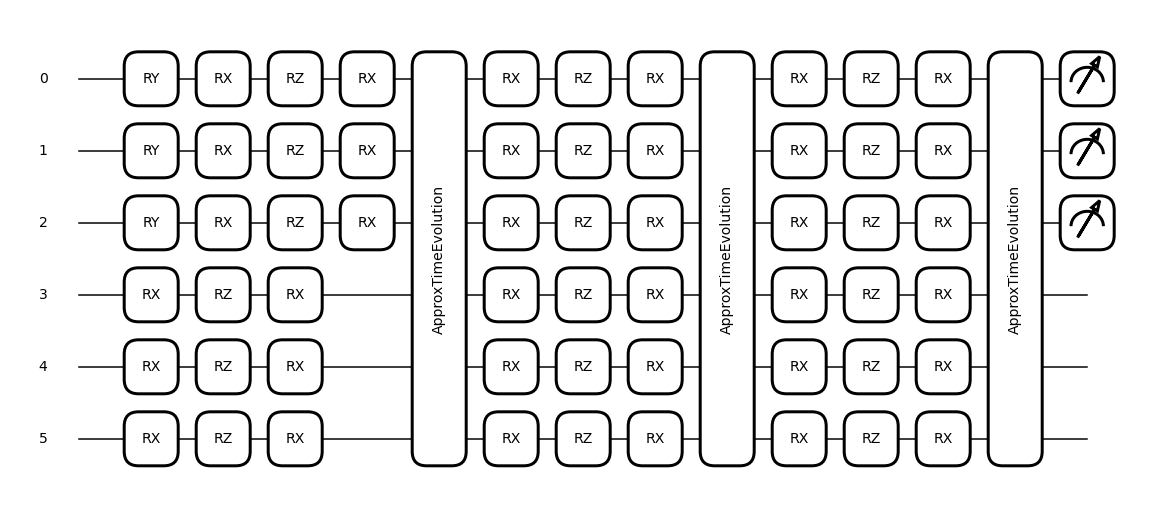

In [ ]:
dev = qml.device("default.qubit", wires=6)
# wires 0,1,2 are group B (input training data)
# wires 3,4,5 are group A (store past data)

# initialize a, J values (stays same throughout trainig)
a = []
J = np.zeros((6, 6))
for i in range(6):
  a.append( np.random.uniform(-1.0, 1.0) )
  for j in range(i):
    J[i][j] = np.random.uniform(-1.0, 1.0)

# calculate Hint
coeffs = []
obs = []
for j in range(6):
    coeffs.append(a[j])
    obs.append(qml.PauliX(j))
    for k in range(j):
      coeffs.append(J[j][k])
      obs.append(qml.PauliZ(j) @ qml.PauliZ(k))
Hint = qml.Hamiltonian(coeffs, obs) 
# some fixed values (as specified in paper)
D = 3
tau = 0.2

# Parameters
# alpha_array = np.zeros((D, 6))
# beta_array  = np.zeros((D, 6))
# gamma_array = np.zeros((D, 6))
alpha_array = np.random.rand(D, 6)
beta_array  = np.random.rand(D, 6)
gamma_array = np.random.rand(D, 6)
c = 1.0

def encoding(x):
    qml.RY(np.arccos(x), wires=0)
    qml.RY(np.arccos(x), wires=1)
    qml.RY(np.arccos(x), wires=2)

def U1(alpha, beta, gamma, wire):
     qml.RX(alpha, wires=wire)
     qml.RZ(beta, wires=wire)
     qml.RX(gamma, wires=wire)

def evolution(alpha_array, beta_array, gamma_array):
    for i in range (D): # D = 3
        # U1 rotations
        for j in range(6):
            U1(alpha_array[i][j], beta_array[i][j], gamma_array[i][j], j)

        # np.exp(-1.0*j * Hint * tau) # e^(-i Hint tau)
        #change third paramter (larger is more accurate)
        qml.ApproxTimeEvolution(Hint, tau, 5)

@qml.qnode(dev)
def pqc(x, alpha_array, beta_array, gamma_array):
    encoding(x)
    evolution(alpha_array, beta_array, gamma_array)
    
    return [qml.expval(qml.PauliZ(i)) for i in range(3)]

#def timestep_output(x, weights):
def timestep_output(x, alpha_array, beta_array, gamma_array):
    
    # print(qml.draw_mpl(pqc)(0.5))
    #result = pqc(x, weights[0], weights[1], weights[2])
    result = pqc(x, alpha_array, beta_array, gamma_array)
    # print("Output of pqc: ", result)
    # print("Type of pqc: ", result[0])
    
    # y = c * np.average(result)
    y = c * (( result[0] + result[1] + result[2] ) / 3.0)
    # print("Output of each timestep: ", y)

    return y

#timestep_output(0.7, [alpha_array, beta_array, gamma_array, c])
timestep_output(0.7, alpha_array, beta_array, gamma_array)
print(qml.draw_mpl(pqc)(0.5, alpha_array, beta_array, gamma_array))

# print(qml.draw_mpl(pqc)(0.5, 1))
# print("blahhhhhhhhh", np.arccos(1))


### random code ideas, unused

# expval1 = qml.expval(qml.PauliZ(0))
# expval2 = qml.expval(qml.PauliZ(1))
# expval3 = qml.expval(qml.PauliZ(2))

# avg = (expval1 + expval2 + expval3) / 3.0

# print([expval1.eigvals(), expval2.eigvals(), expval3.eigvals()])

# return c * avg
# return expval1, expval2, expval3

In [ ]:
timestep_output(0.7, [alpha_array, beta_array, gamma_array, c])

tensor(0.2723061, requires_grad=True)

In [ ]:
len(pqc.qtape.trainable_params)

99

In [ ]:
alpha_array

tensor([[0.26998174, 0.02886986, 0.29501369, 0.22941066, 0.34502591,
         0.60700777],
        [0.39825945, 0.41736862, 0.82289055, 0.99347846, 0.15666884,
         0.98427225],
        [0.99658212, 0.89925161, 0.6368892 , 0.02120434, 0.08892392,
         0.70699909]], requires_grad=True)

[0.5, 0.45979899497487436, 0.41959798994974873, 0.37939698492462315, 0.33919597989949746, 0.2989949748743719, 0.25879396984924624, 0.2185929648241206, 0.17839195979899497, 0.13819095477386933, 0.0979899497487437, 0.05778894472361806, 0.017587939698492483, -0.022613065326633208, -0.06281407035175879, -0.10301507537688448, -0.14321608040201006, -0.18341708542713564, -0.22361809045226133, -0.2638190954773869]
[0.45979899497487436, 0.41959798994974873, 0.37939698492462315, 0.33919597989949746, 0.2989949748743719, 0.25879396984924624, 0.2185929648241206, 0.17839195979899497, 0.13819095477386933, 0.0979899497487437, 0.05778894472361806, 0.017587939698492483, -0.022613065326633208, -0.06281407035175879, -0.10301507537688448, -0.14321608040201006, -0.18341708542713564, -0.22361809045226133, -0.2638190954773869, -0.3040201005025126]


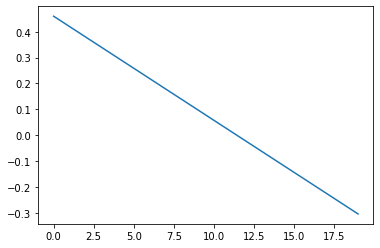

In [ ]:
def generate_input(t_in):
    t=8/199*t_in
    if t>=0 and t<=1:
        return -t+0.5
    elif t>=1 and t<=2:
        return t-1.5
    elif t>=2 and t<=3:
        return -t+2.5
    else:
        return t-3.5

train_inputs = []
train_expected_outputs = []

for i in range(20):
    train_inputs.append(generate_input(i))
    train_expected_outputs.append(generate_input(i+1))

print(train_inputs)
print(train_expected_outputs)
plt.plot(train_expected_outputs)

In [ ]:
### Lecture 8 Demo helper functions

#def make_predictions(data, model, weights):
def make_predictions(data, model, alpha_array, beta_array, gamma_array):

    """Predict the labels of all points in a data set for a given model.
    
    Args:
        data (array[float]): Input data. A list with shape N x 2
            representing points on a 2D plane.
        model (qml.QNode): A QNode whose output expectation value will be
            used to make predictions of the labels of data.
        weights (array[float]): The trainable model parameters for the QNode. 
            
    Returns:
        array[int]: The array of predictions for each data point made by 
        the model QNode. 
    """
    preds = []
    
    for idx in range(len(data)):
        estimated_expval = model(data[idx], alpha_array, beta_array, gamma_array)
        
        preds.append(estimated_expval)
        #if estimated_expval > 0:
        #    preds.append(1)
        #else:
        #    preds.append(-1)
            
    return preds

def make_loss_function(data, labels, model):

    #def loss(weights):
    def loss(alpha_array, beta_array, gamma_array):
        loss_sum = 0.0

        for idx in range(len(data)):
            point = data[idx]
            true_expval = labels[idx]

            #estimated_expval = model(point, weights)
            estimated_expval = model(point, alpha_array, beta_array, gamma_array)
            loss_sum += (estimated_expval - true_expval) ** 2
            # Bobby's change - Not working lol
            #loss_sum += (estimated_expval - true_expval)

        return loss_sum / len(data)
    
    return loss

def compute_accuracy(predictions, true_labels):
    """Compute the accuracy of our predictions.
    
    Args:
        predictions (array[int]): Predicted values to 
        true_labels (array[int]): Integers identifying the class/label of 
            each data point.
    
    Returns:
        float: Accuracy of the predictions, returned as a percentage.
    """    
    n_samples = len(predictions)
    
    return np.sum(
        [predictions[x] == true_labels[x] for x in range(n_samples)
    ]) / n_samples

In [ ]:
loss = make_loss_function(train_inputs, train_expected_outputs, timestep_output)

In [ ]:
gradient_function = qml.grad(timestep_output)

In [ ]:
#tune this parameter!
opt = qml.GradientDescentOptimizer(stepsize=0.1)

n_its = 100

loss_track = []

# weights = [alpha_array, beta_array, gamma_array, c]
# weights = np.array([alpha_array, beta_array, gamma_array, c], requires_grad=True).tolist()

for it in range(n_its):
    #weights, _loss = opt.step_and_cost(loss, weights)
    # Add c as a trainable parameter
    (alpha_array, beta_array, gamma_array, c), _loss = opt.step_and_cost(loss, alpha_array, beta_array, gamma_array, c)

    if it % 5 == 0:
        #our_preds = make_predictions(train_inputs, timestep_output, weights)
        our_preds = make_predictions(train_inputs, timestep_output, alpha_array, beta_array, gamma_array)
        print(f"Loss at iteration {it} = {_loss}  Accuracy = {compute_accuracy(our_preds, train_expected_outputs)}")
    loss_track.append(_loss)

Loss at iteration 0 = 0.4574551903399513  Accuracy = 0.0
Loss at iteration 5 = 0.27203435164099127  Accuracy = 0.0
Loss at iteration 10 = 0.1450830129977006  Accuracy = 0.0
Loss at iteration 15 = 0.07812632460045028  Accuracy = 0.0
Loss at iteration 20 = 0.04889267773753506  Accuracy = 0.0
Loss at iteration 25 = 0.036424973368228655  Accuracy = 0.0
Loss at iteration 30 = 0.030197412879235136  Accuracy = 0.0
Loss at iteration 35 = 0.026250247432394725  Accuracy = 0.0
Loss at iteration 40 = 0.023255243644622163  Accuracy = 0.0
Loss at iteration 45 = 0.020771376632431806  Accuracy = 0.0
Loss at iteration 50 = 0.01863778433213147  Accuracy = 0.0
Loss at iteration 55 = 0.016781276373167685  Accuracy = 0.0
Loss at iteration 60 = 0.015157600308009236  Accuracy = 0.0
Loss at iteration 65 = 0.013733730911329917  Accuracy = 0.0
Loss at iteration 70 = 0.012482436005446752  Accuracy = 0.0
Loss at iteration 75 = 0.011380460609405684  Accuracy = 0.0
Loss at iteration 80 = 0.010407764794282622  Accur

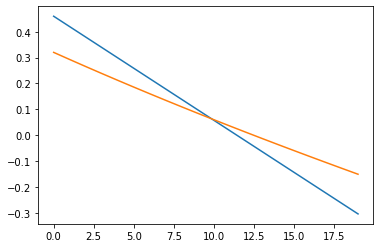

In [ ]:
plt.plot(train_expected_outputs)
plt.plot(our_preds)

In [ ]:
weights

In [ ]:
# weights = np.random.normal(size=(2, 3), requires_grad=True)
weights = np.array([alpha_array, beta_array, gamma_array, c], requires_grad=True).tolist()
weights